## `+` Import Libraries

In [ ]:
import gdown
import os
import glob as glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose, Concatenate
from keras.callbacks import EarlyStopping

# `+` Seed Value

In [ ]:
SEED = 907

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=5b1364cd-61b3-408f-af12-6507d81c0468
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 77.0MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
!unzip Lung_Data.zip

In [ ]:
#to convert extension from bmp to png
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob.glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [ ]:
SEED = 524
BATCH_SIZE = 8
EPOCHS = 50

In [ ]:
grey_train, grey_valid = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both"
                                                )

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [ ]:
mask_train, mask_valid = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


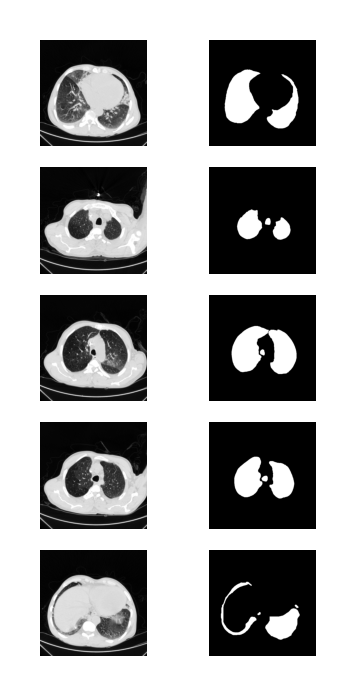

In [ ]:
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(grey_train.take(4), mask_train.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
# Training Dataset
def augment_data(images, layers):
    for layer in layers:
        images = layer(images)
    return images
layers = [Rescaling(1/225.0),RandomFlip(seed=8), RandomRotation(0.2,seed=8)]
augmented_train = grey_train.map(lambda x: augment_data(x, layers))
augmented_mask = mask_train.map(lambda x: augment_data(x, layers))


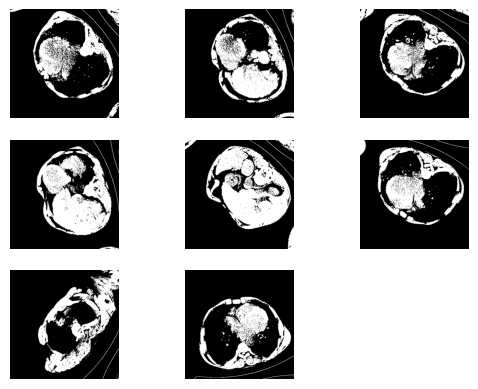

In [ ]:
for images in augmented_train.take(4):
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'),cmap='gray')
    plt.axis('off')

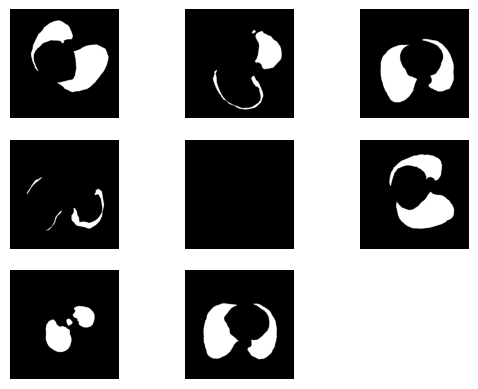

In [ ]:
# Validation Dataset
for images in augmented_mask.take(4):
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'),cmap='gray')
    plt.axis('off')

## `i` Model Design

In [ ]:
def double_conv(x, n_filters):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv(x, n_filters)
    p = MaxPool2D()(f)
    return f, p
def upsample_block(x, n_filters, skip_features):
    x = Conv2DTranspose(n_filters, (3, 3), 2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = double_conv(x, n_filters)
    return x

In [ ]:
inputs = Input((512, 512, 1))
x = Rescaling(1./255)(inputs)

# Encoder
f1, p1 = downsample_block(x, 32)
f2, p2 = downsample_block(p1, 64)
f3, p3 = downsample_block(p2, 128)
f4, p4 = downsample_block(p3, 256)

# Bottleneck
bottleneck = double_conv(p4, 512)

# Decoder
u1 = upsample_block(bottleneck, 256, f4)
u2 = upsample_block(u1, 128, f3)
u3 = upsample_block(u2, 64, f2)
u4 = upsample_block(u3, 32, f1)

# Output
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u4)

model = Model(inputs, outputs, name="lung_UNet")
model.summary()


Model: "lung_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [ ]:
model.compile(keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
segment_train = tf.data.Dataset.zip(grey_train, mask_train.map(lambda x: Rescaling(1./255)(x)))
segment_val = tf.data.Dataset.zip(grey_valid, mask_valid.map(lambda x: Rescaling(1./255)(x)))

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history=model.fit(
    x=segment_train,
    epochs=EPOCHS,
    validation_data=segment_val,
    callbacks=[early_stopping],
    steps_per_epoch=grey_train.cardinality().numpy(),
    validation_steps=grey_valid.cardinality().numpy(),
    batch_size=BATCH_SIZE

)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4768 - loss: 0.7920 - val_accuracy: 0.9031 - val_loss: 0.3803
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - accuracy: 0.8864 - loss: 0.4040 - val_accuracy: 0.9023 - val_loss: 0.2415
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 628ms/step - accuracy: 0.8835 - loss: 0.2516 - val_accuracy: 0.9045 - val_loss: 0.1784
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 630ms/step - accuracy: 0.8867 - loss: 0.2002 - val_accuracy: 0.9043 - val_loss: 0.3498
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 665ms/step - accuracy: 0.8890 - loss: 0.3325 - val_accuracy: 0.9045 - val_loss: 0.1941
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.8852 - loss: 0.2116 - val_accuracy: 0.9045 - val_loss: 0.1575
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - accuracy: 0.8881 - loss: 0.1713 - val_accuracy: 0.9643 - val_loss: 0.1254
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 656ms/step - accuracy: 0.9595 - loss: 0.1133 - val_accurac

## `iii` Model Evaluation

In [ ]:
model.evaluate(segment_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9960 - loss: 0.0101


[0.009889405220746994, 0.9961098432540894]

## `iv` Result Visualization

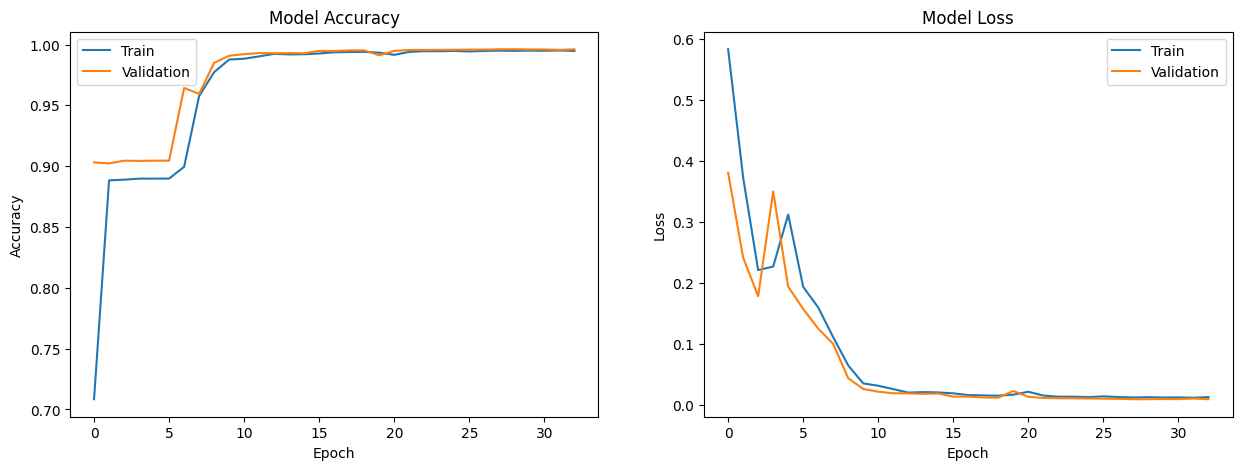

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],loc='upper right')
plt.show()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
preds = model.predict(grey_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


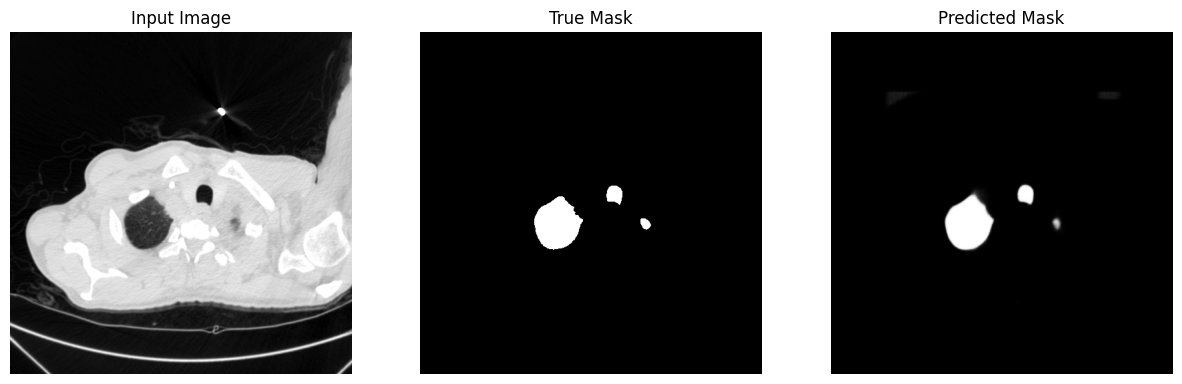

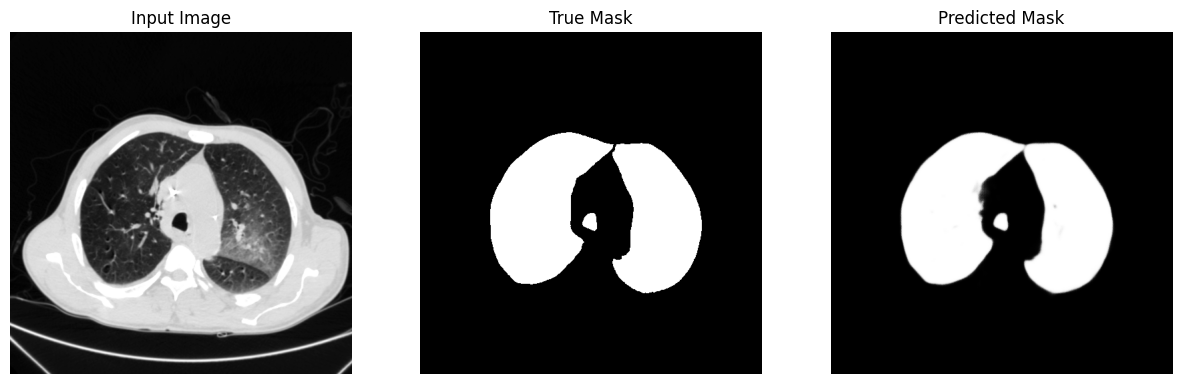

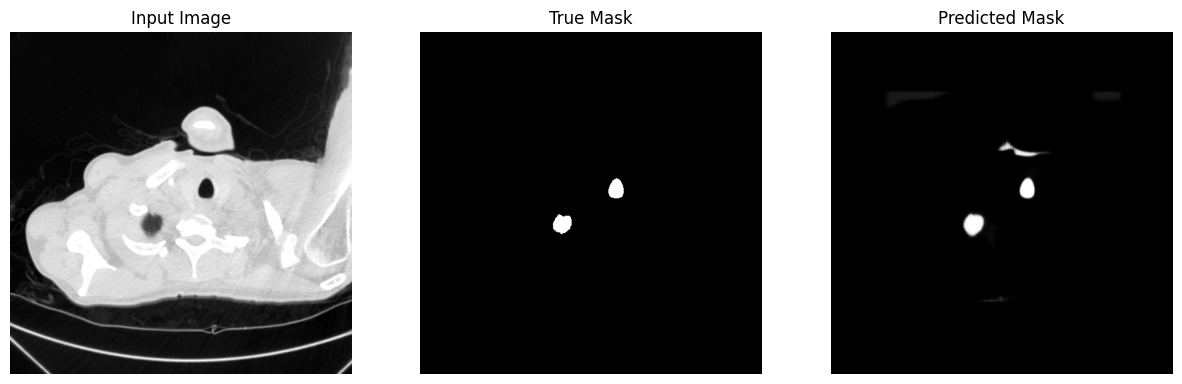

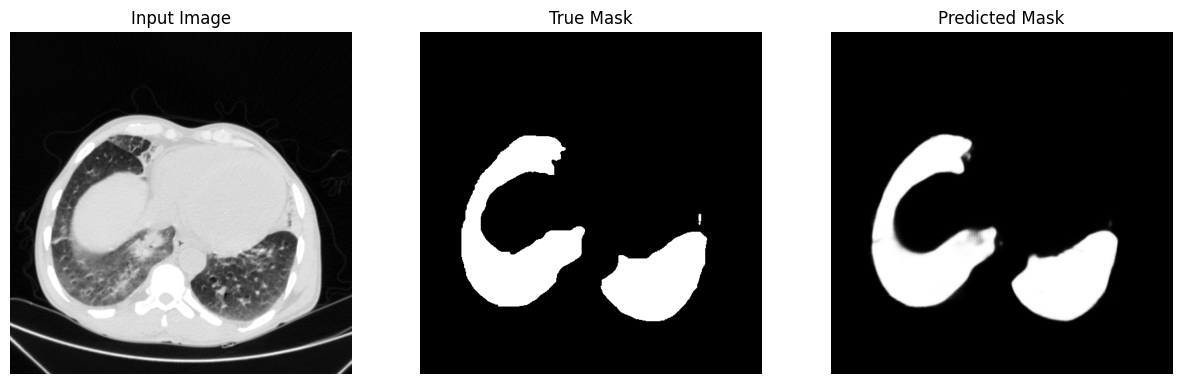

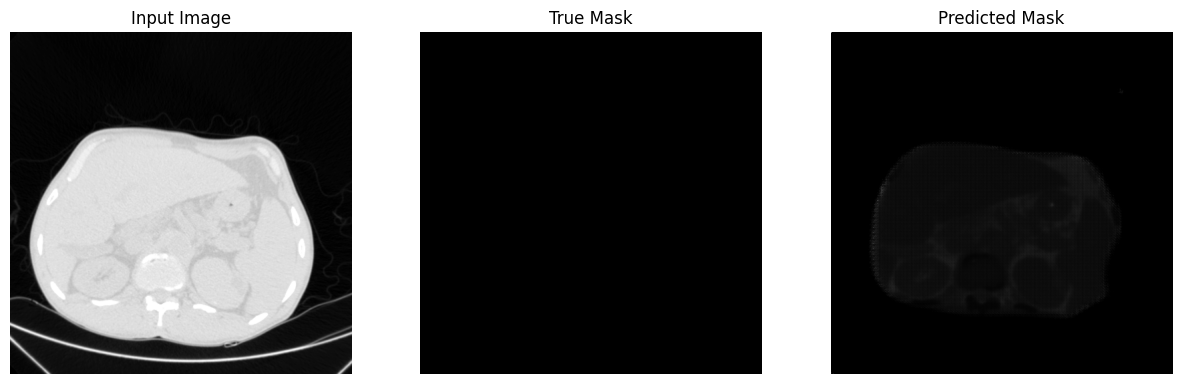

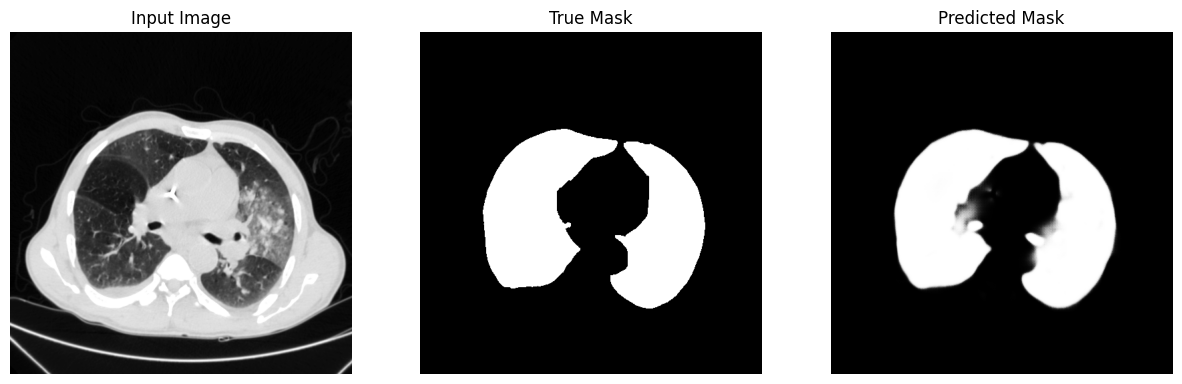

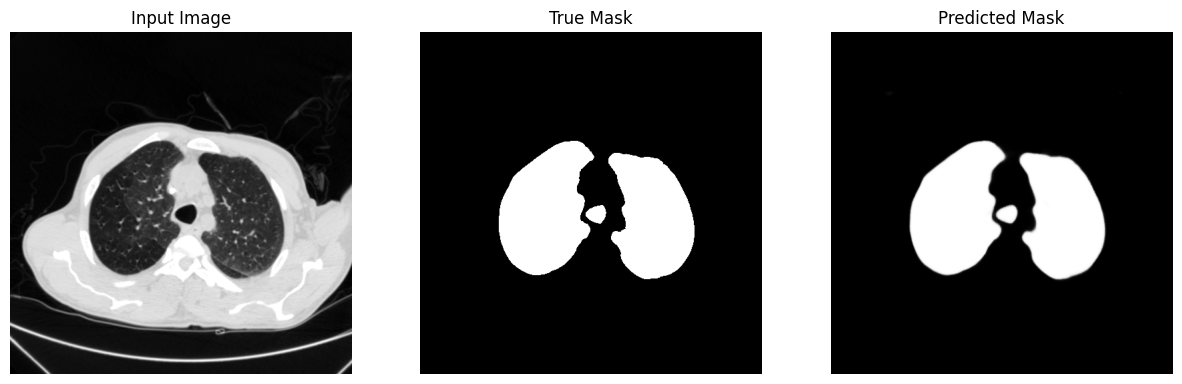

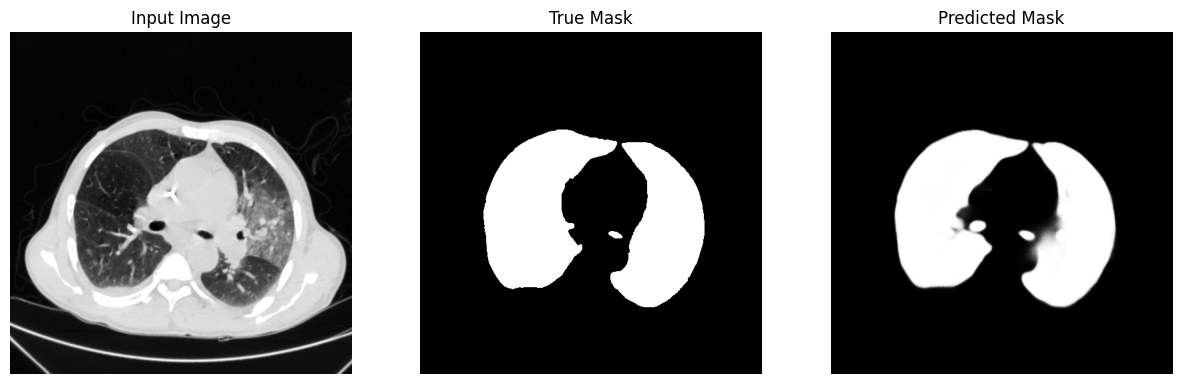

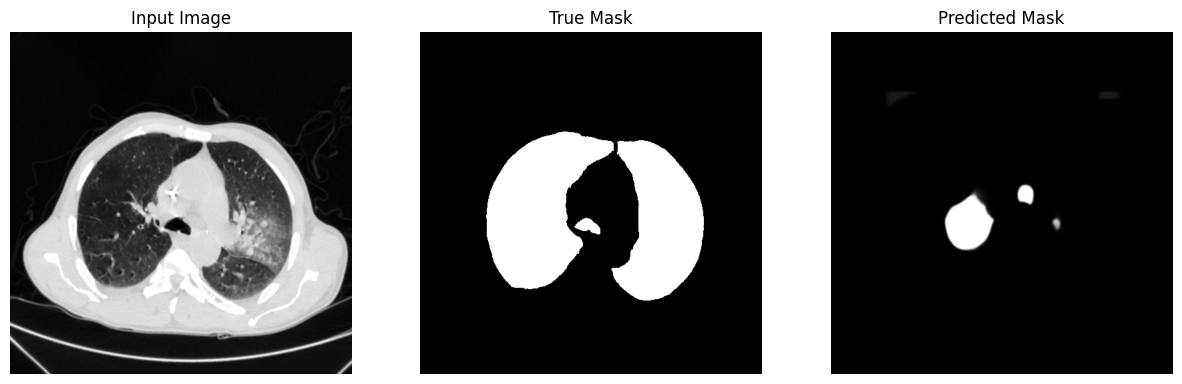

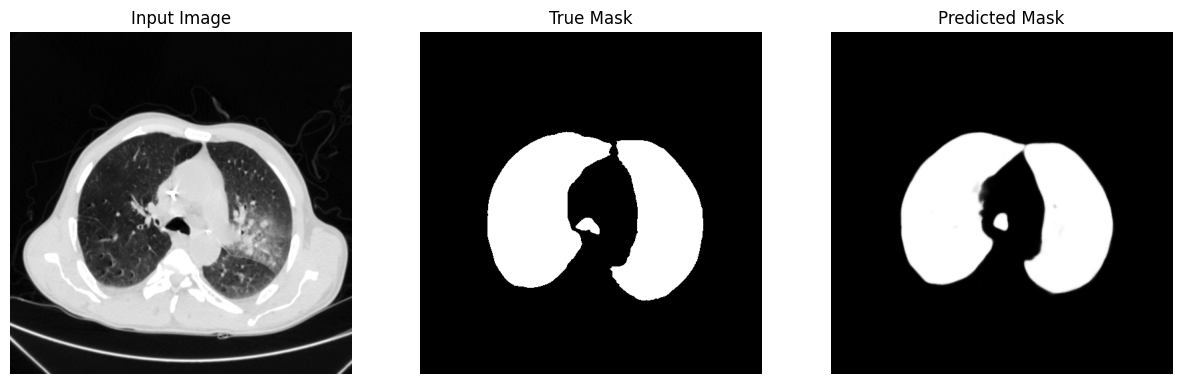

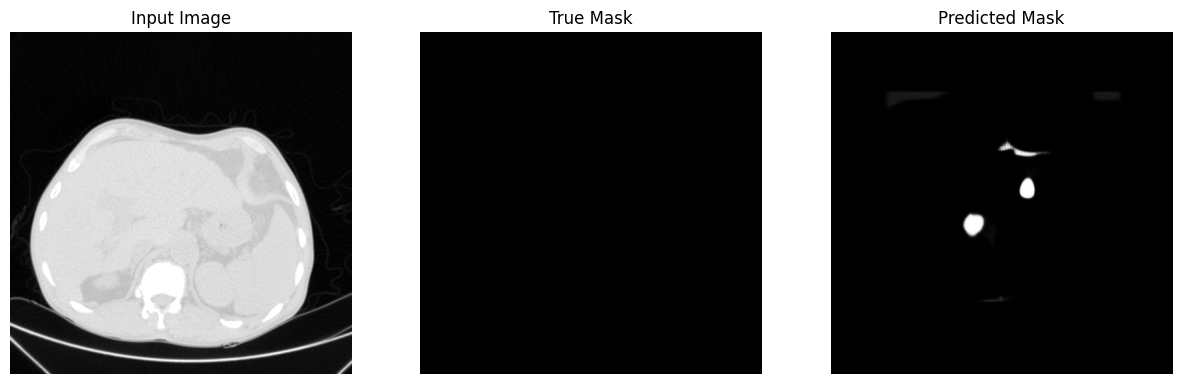

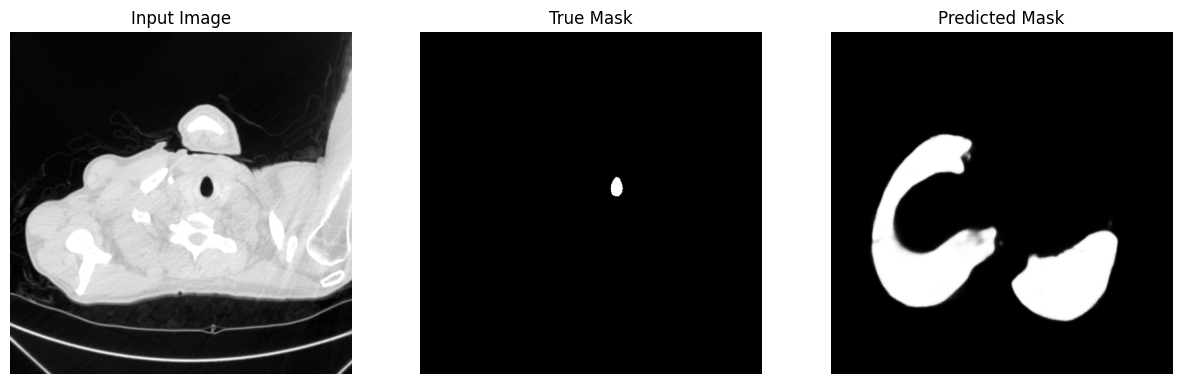

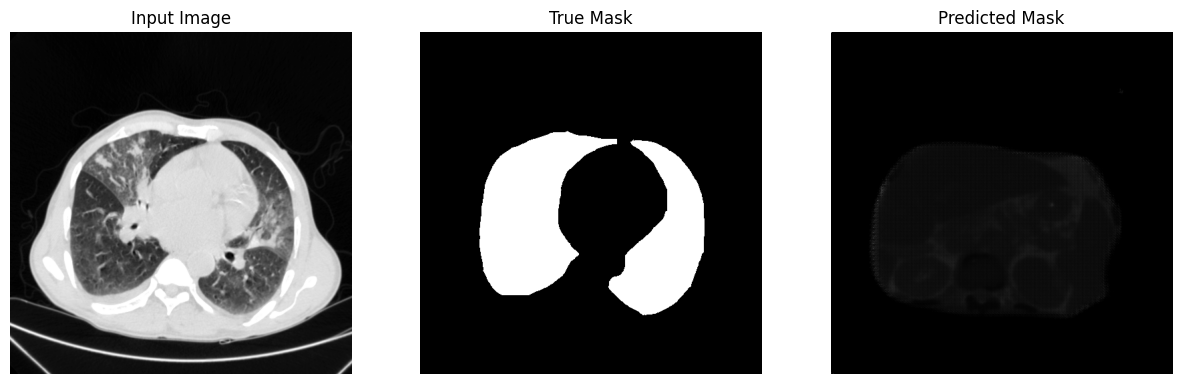

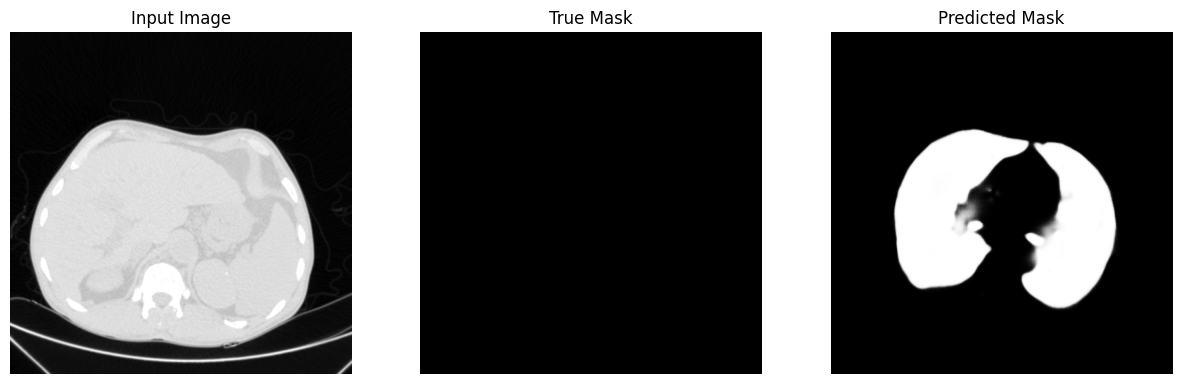

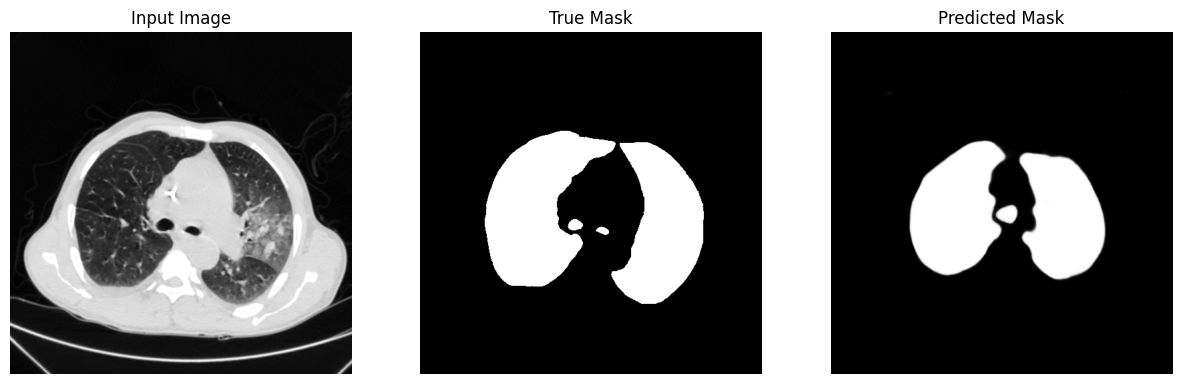

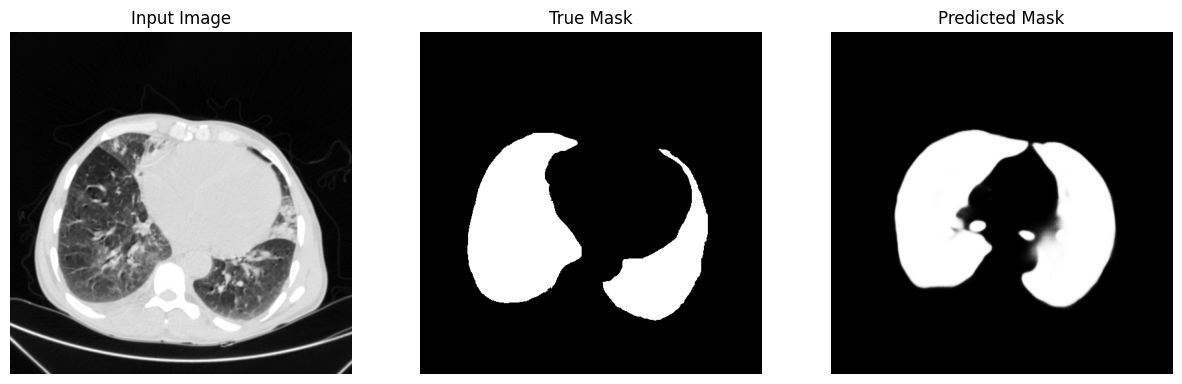

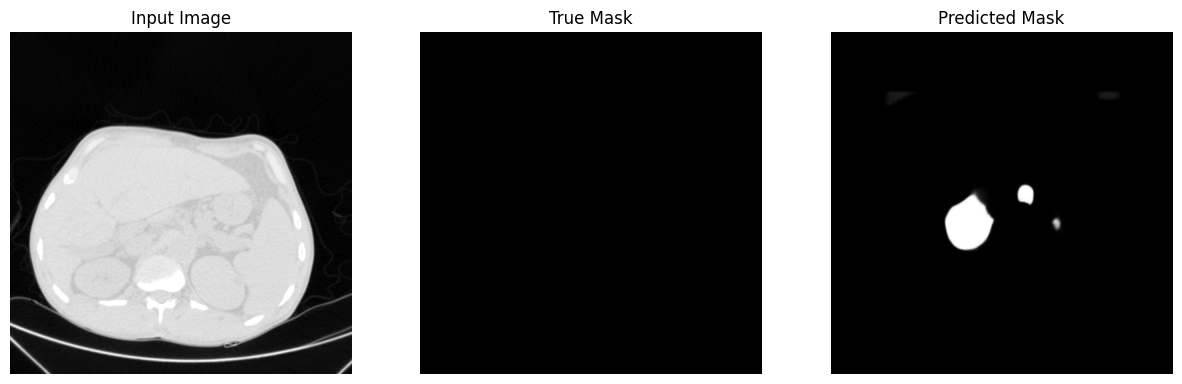

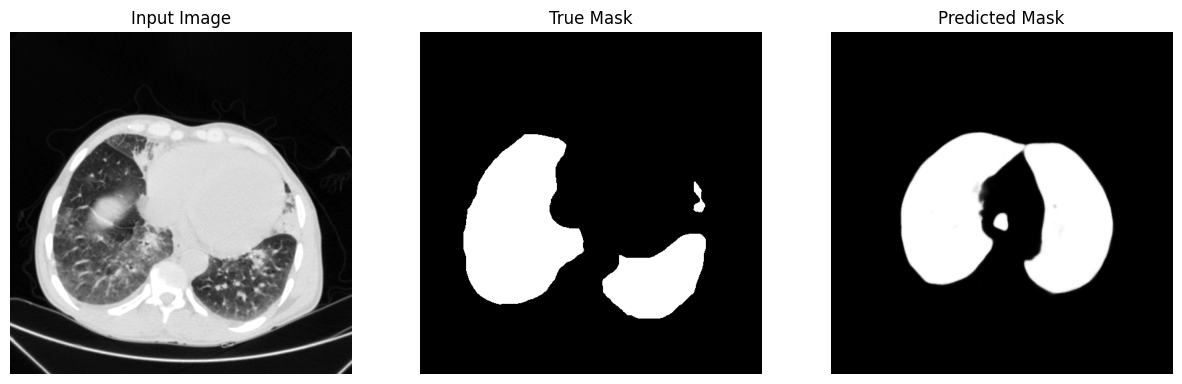

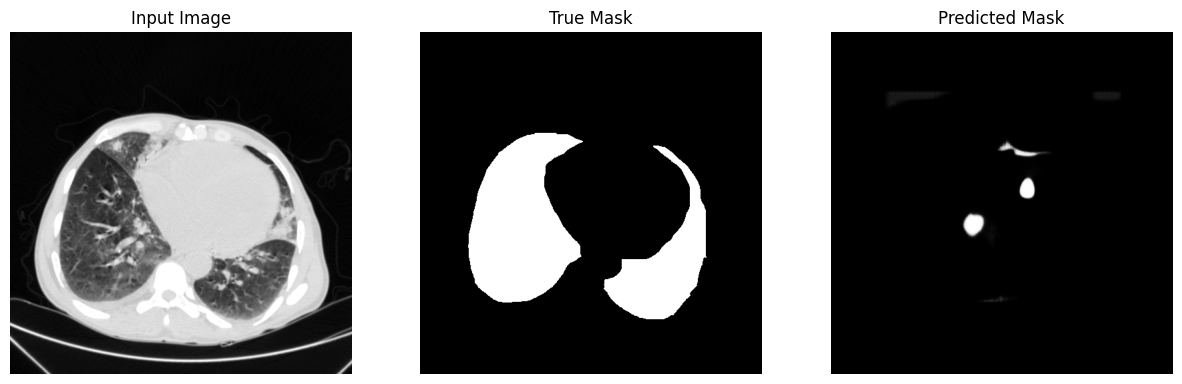

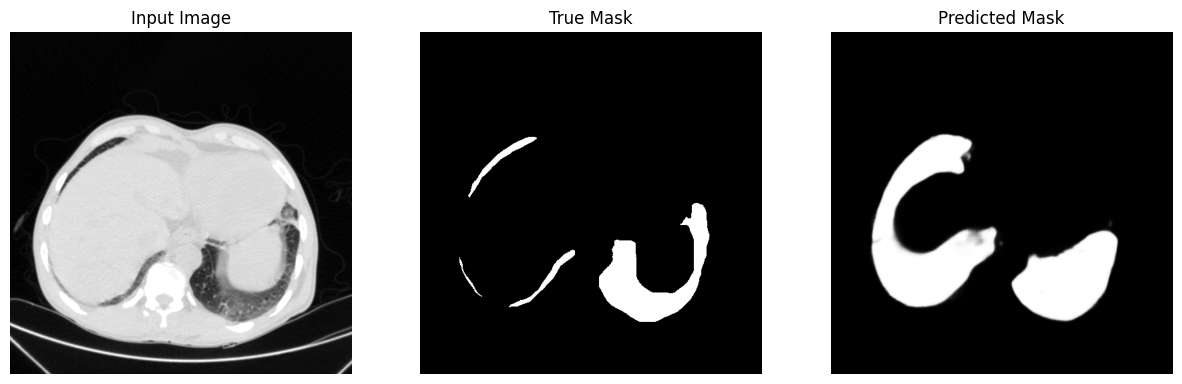

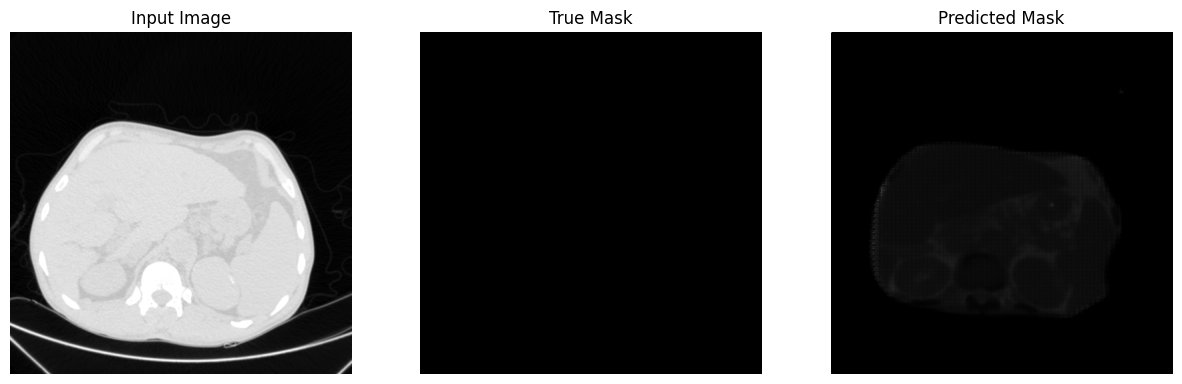

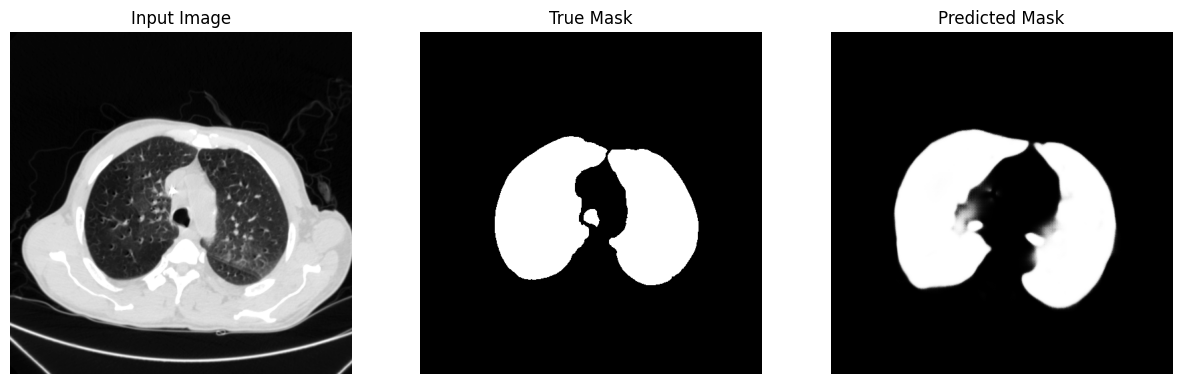

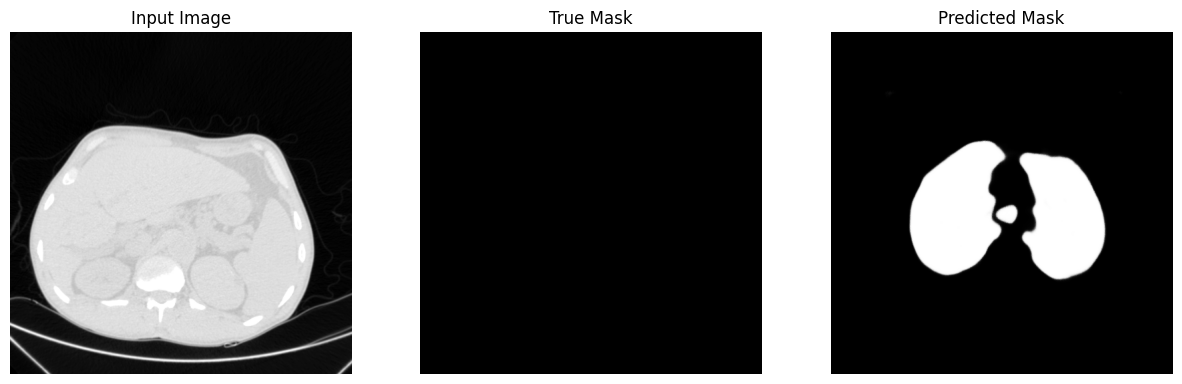

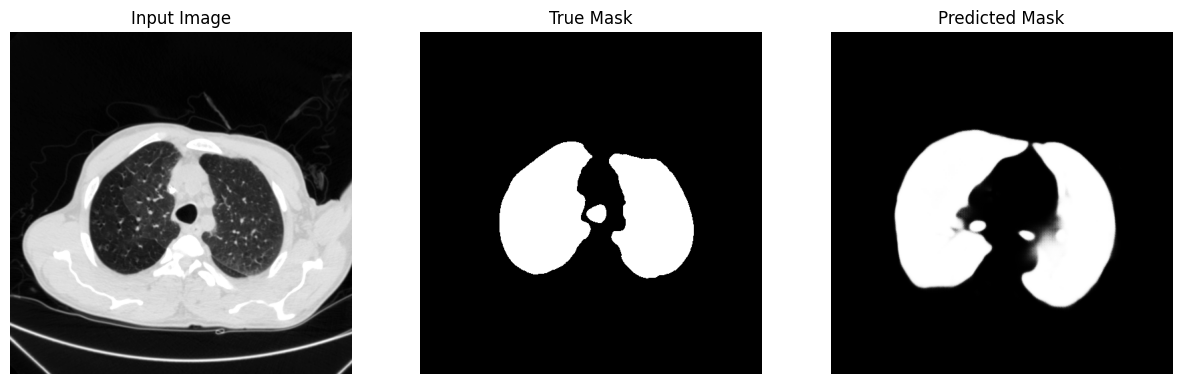

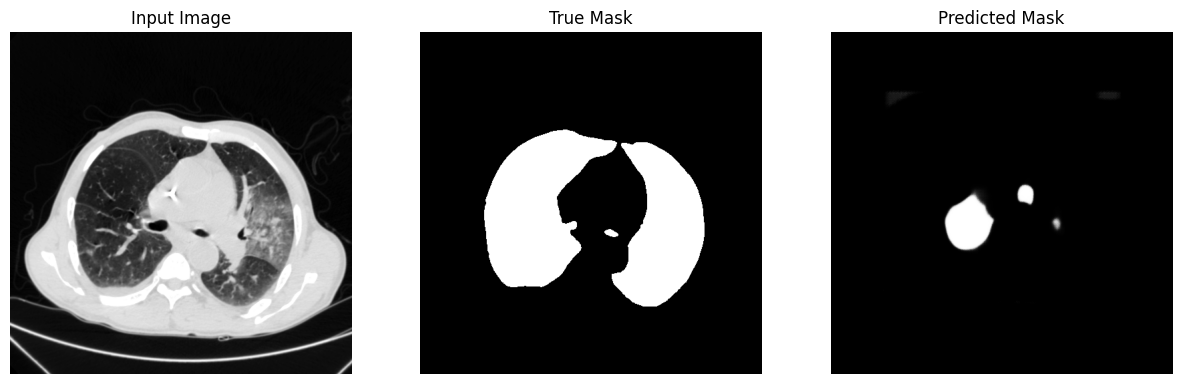

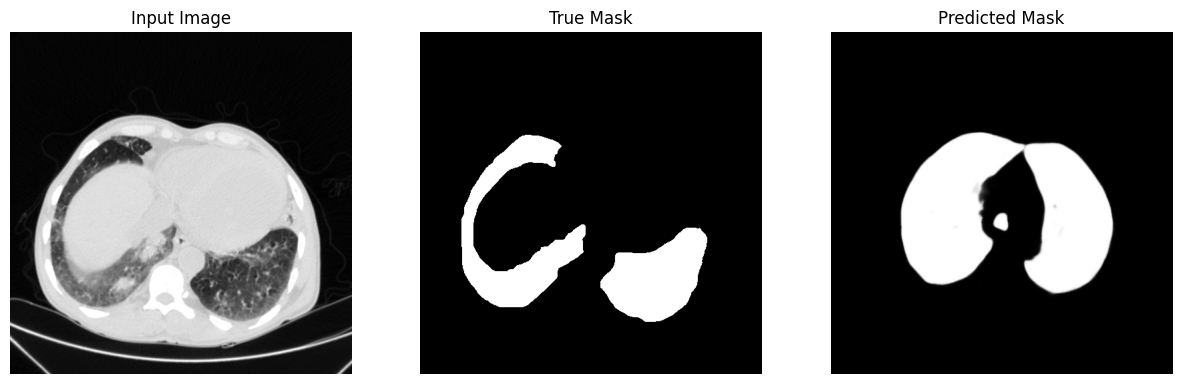

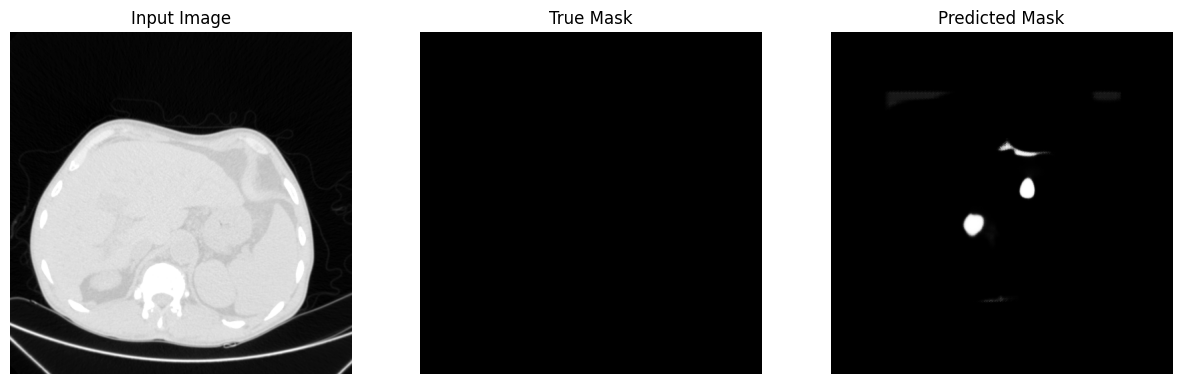

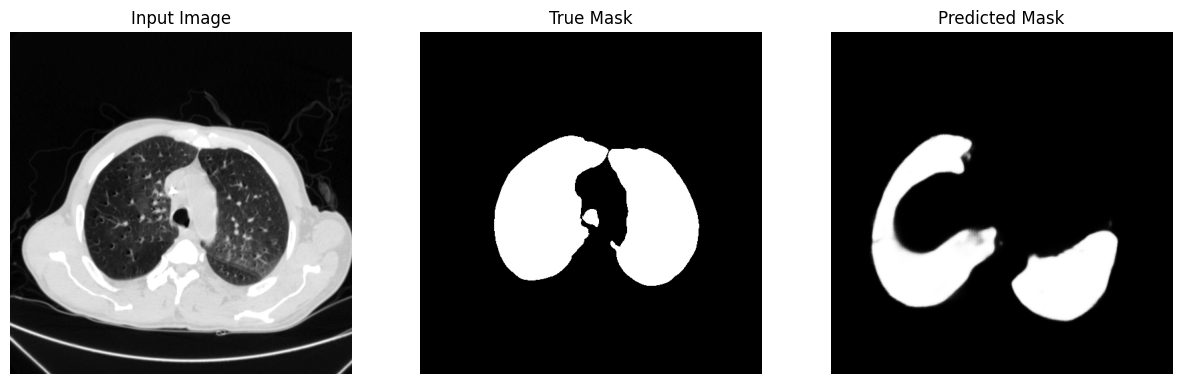

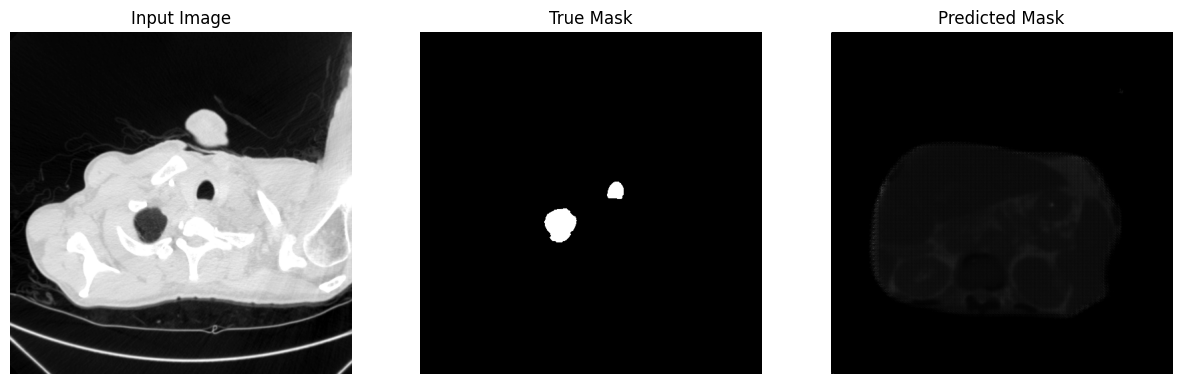

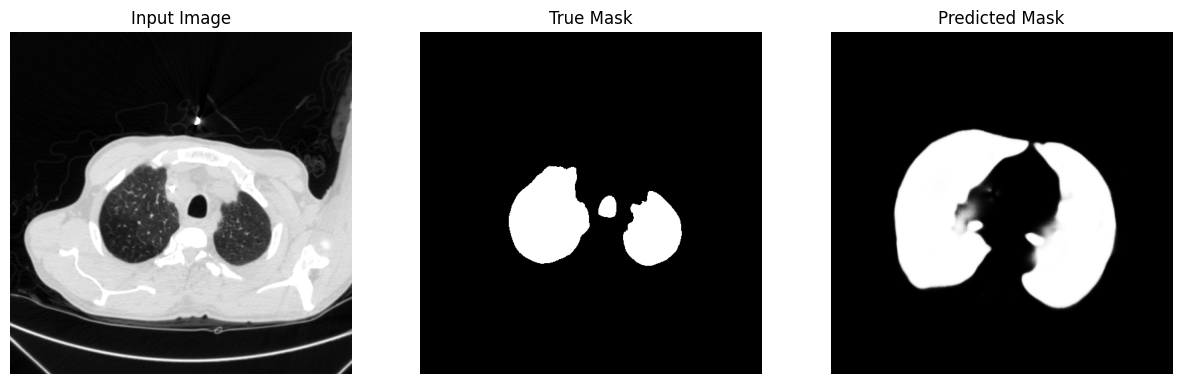

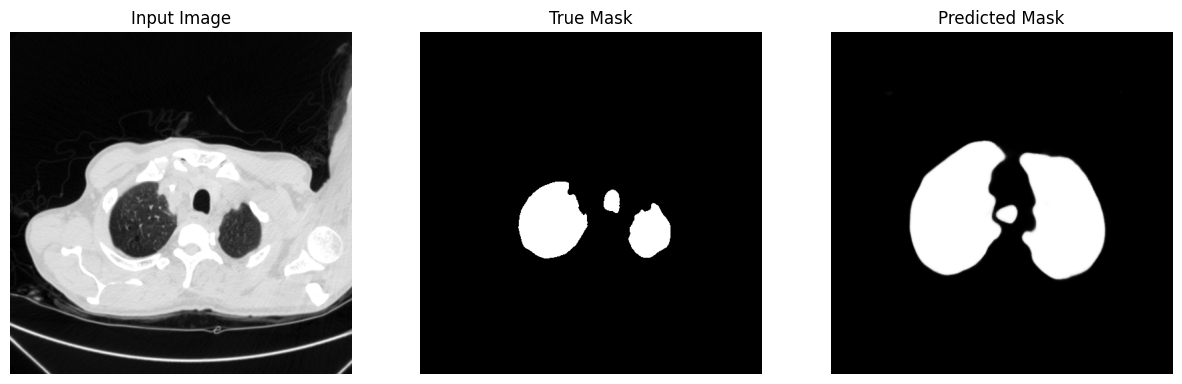

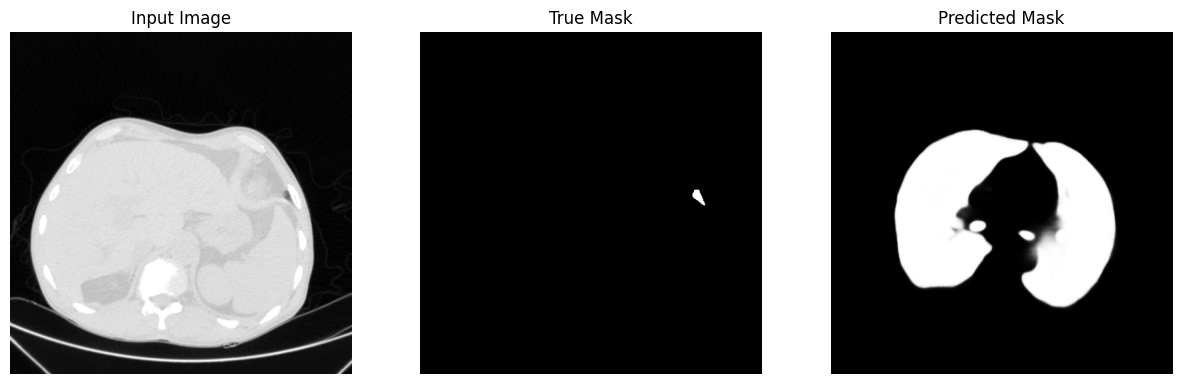

In [ ]:
for images, masks in zip(grey_valid.take(4), mask_valid.take(4)):
    for i in range(images.shape[0]):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().astype('uint8'), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()